# Neural Oblivious Decision Ensembles

NODE is a deep learning architecture designed specifically for tabular data, introduced by Yandex researchers in 2019. It blends the strengths of decision trees with neural networks by using differentiable oblivious decision trees trained end-to-end via gradient descent.

Core Concept
Unlike classical decision trees that use hard binary splits, NODE employs soft splits implemented with sigmoid functions, making the decision process differentiable. This allows NODE to be trained with standard backpropagation.

Oblivious Decision Trees
NODE uses oblivious trees, where each level in the tree applies the same feature-based split. This constraint simplifies model structure and enables efficient vectorized implementations.

Ensemble Structure
The model consists of an ensemble of such oblivious trees, each producing outputs that are aggregated to form the final prediction. This ensemble approach improves model robustness and generalization.



---



# Environment Setup and Library Imports

In [14]:
!pip install -q torch torchvision torchaudio tensorflow pandas numpy scikit-learn matplotlib

In [26]:
!git clone https://github.com/Qwicen/node.git

import sys
sys.path.append('/content/node')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving preprocessed_dataset.csv to preprocessed_dataset (1).csv


In [19]:
!touch /content/node/lib/__init__.py

In [21]:
!find . -name "arch.py"

./node/lib/arch.py


In [22]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.4 MB/s eta 0:00:00


In [27]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.7 MB/s eta 0:00:00


# Data Loading and Preprocessing

In this section, the necessary libraries for data processing, visualization, and modeling are imported. The dataset is read from a CSV file, and the target column 'No-show' is renamed to 'NoShow' for easier access in code.

The target variable y is defined as the 'NoShow' column, while the feature matrix X contains all other columns. These features represent patient information and appointment-related details.

To evaluate model performance reliably, the dataset is split into training and testing subsets using an 80/20 ratio.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from lib.arch import DenseBlock
from lib.odst import ODST
from lib.trainer import Trainer
from lib.nn_utils import sparsemax, Entmax15Function

df = pd.read_csv(next(iter(uploaded)))
print(f"Input dimension: {df.shape[1] - 1}")

df.rename(columns={'No-show': 'NoShow'}, inplace=True)

# Target and Features
y = df['NoShow']
X = df.drop(columns=['NoShow'])

feature_names = df.drop(columns=['NoShow']).columns

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Class distribution in original train:", np.bincount(y_train))
print("Class distribution in test:          ", np.bincount(y_test))

Input dimension: 148
Class distribution in original train: [70565 17855]
Class distribution in test:           [17642  4464]


# Model Building, Training, and Evaluation

This section describes the end-to-end modeling process using a custom deep learning model that incorporates a tree-based architecture via DenseBlock and ODST, integrated with PyTorch.

###  Data Conversion & Loading
The training and test datasets are converted from NumPy arrays to PyTorch tensors and wrapped into DataLoader objects with a batch size of 256. This makes it efficient to feed batches into the model during training.

###  Model Definition
A class ModelWithDenseBlock is defined. It uses a DenseBlock composed of multiple ODST (Oblivious Decision Tree) layers, followed by a fully connected classifier layer to output probabilities for the two classes (Show / No-Show). Custom sparse activation functions (sparsemax and entmax15) are applied to improve decision boundaries.

###  Training Setup
The model is trained using the Adam optimizer with a learning rate of 0.001 and CrossEntropyLoss as the loss function. The training loop runs for a maximum of 20 epochs. Early stopping is implemented with a patience of 5 to avoid overfitting — it stops training if validation loss doesn’t improve for 5 consecutive epochs.

###  Evaluation
After training, the best model checkpoint is loaded, and predictions are made on the test set. The predicted probabilities are thresholded at 0.5 to generate final binary predictions. A classification report is printed, showing precision, recall, and F1-score. Additionally, the ROC curve is plotted to visualize the model's ability to distinguish between classes across different thresholds, and the AUC (Area Under Curve) score is calculated to summarize performance.

using automatic experiment name: untitled_2025.05.18_15:04
Epoch 1/20 - Train Loss: 0.4967 - Val Loss: 0.4852
Saved logs/untitled_2025.05.18_15:04/checkpoint_best.pth
Epoch 2/20 - Train Loss: 0.4856 - Val Loss: 0.4852
Epoch 3/20 - Train Loss: 0.4869 - Val Loss: 0.4889
Epoch 4/20 - Train Loss: 0.4860 - Val Loss: 0.4905
Epoch 5/20 - Train Loss: 0.4864 - Val Loss: 0.4844
Saved logs/untitled_2025.05.18_15:04/checkpoint_best.pth
Epoch 6/20 - Train Loss: 0.4857 - Val Loss: 0.4842
Saved logs/untitled_2025.05.18_15:04/checkpoint_best.pth
Epoch 7/20 - Train Loss: 0.4843 - Val Loss: 0.4862
Epoch 8/20 - Train Loss: 0.4849 - Val Loss: 0.4847
Epoch 9/20 - Train Loss: 0.4848 - Val Loss: 0.4839
Saved logs/untitled_2025.05.18_15:04/checkpoint_best.pth
Epoch 10/20 - Train Loss: 0.4833 - Val Loss: 0.4826
Saved logs/untitled_2025.05.18_15:04/checkpoint_best.pth
Epoch 11/20 - Train Loss: 0.4841 - Val Loss: 0.4842
Epoch 12/20 - Train Loss: 0.4829 - Val Loss: 0.4832
Epoch 13/20 - Train Loss: 0.4833 - Val Lo

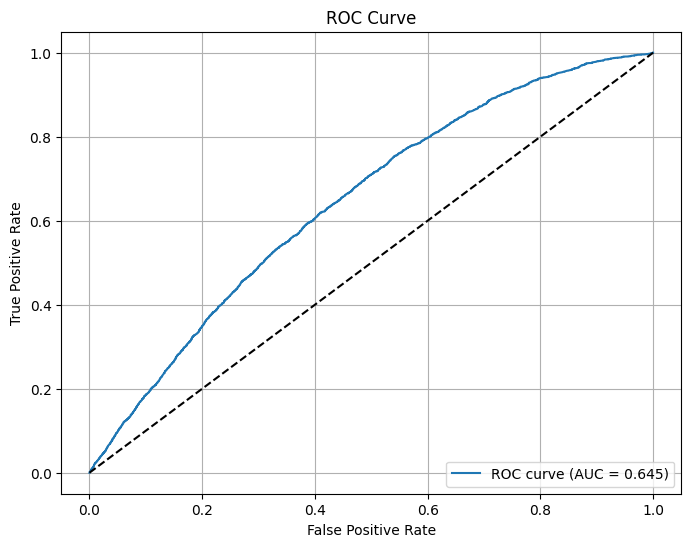

In [42]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=256)

# Define model
class ModelWithDenseBlock(torch.nn.Module):
    def __init__(self, input_dim, num_trees, num_layers, depth, tree_dim,
                 choice_function, bin_function):
        super().__init__()
        self.dense_block = DenseBlock(
            input_dim=input_dim,
            layer_dim=num_trees,    # pass num_trees here to fit ODST signature
            num_layers=num_layers,
            tree_dim=tree_dim,
            flatten_output=True,
            Module=ODST,
            depth=depth,
            choice_function=choice_function,
            bin_function=bin_function
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, input_dim)
            dense_output = self.dense_block(dummy_input)
            dense_output_dim = dense_output.shape[1]

        self.classifier = torch.nn.Linear(dense_output_dim, 2)  # binary classification

    def forward(self, x):
        x = self.dense_block(x)
        x = self.classifier(x)
        return x
entmax15 = lambda input, dim=-1: Entmax15Function.apply(input, dim)

model = ModelWithDenseBlock(
    input_dim=X_train.shape[1],
    num_trees=100,    # your desired num_trees
    num_layers=3,
    depth=5,          # corresponds to ODST's depth
    tree_dim=1,
    choice_function=entmax15,
    bin_function=sparsemax
)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
trainer = Trainer(
    model=model,
    loss_function=loss_fn,
    Optimizer=torch.optim.Adam,
    optimizer_params={'lr': 0.001},
    verbose=True
)

trainer.model.to(device)

num_epochs = 20
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        batch_result = trainer.train_on_batch(inputs, labels, device=device)
        total_loss += batch_result['loss'].item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save checkpoint
        trainer.save_checkpoint(tag='best')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

trainer.load_checkpoint(tag='best')
model.eval()

y_pred_probs = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_pred_probs.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)
y_pred = y_pred_probs > 0.5

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

auc = roc_auc_score(y_true, y_pred_probs)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Training Performance Analysis
The training logs show a relatively stable but limited improvement in both training and validation loss over 15 epochs. The model started with a training loss of 0.4967 and gradually improved to 0.4831 before early stopping triggered at epoch 15. The best validation loss achieved was 0.4826, which occurred at epochs 10 and 15. This small gap between training and validation loss suggests the model isn't overfitting, but the minimal improvement in loss values indicates the model struggled to learn more complex patterns in the data. The early stopping mechanism appropriately prevented unnecessary training when performance plateaued.

## Prediction Performance Analysis

The ROC curve shows moderate discriminative ability with an AUC of 0.645, which is better than random guessing (0.5) but not strong. The classification report reveals a significant class imbalance issue - while the model achieves 80% accuracy, this is largely due to correctly predicting the majority class (class 0, likely representing "no-show = false") with 100% recall. However, the model performs poorly on the minority class (class 1, "no-show = true") with only 1% recall and 36% precision. This indicates that the model essentially defaults to predicting the majority class and rarely identifies actual no-shows. The f1-score of just 0.02 for the minority class confirms this severe imbalance problem. The model needs significant improvement in handling class imbalance, possibly through techniques like SMOTE, class weighting, or threshold adjustments.

In [43]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

using automatic experiment name: untitled_2025.05.18_16:32
Epoch 1/20 - Train Loss: 0.6665 - Val Loss: 0.6953
Saved logs/untitled_2025.05.18_16:32/checkpoint_best_smote.pth
Epoch 2/20 - Train Loss: 0.6534 - Val Loss: 0.6340
Saved logs/untitled_2025.05.18_16:32/checkpoint_best_smote.pth
Epoch 3/20 - Train Loss: 0.6500 - Val Loss: 0.5745
Saved logs/untitled_2025.05.18_16:32/checkpoint_best_smote.pth
Epoch 4/20 - Train Loss: 0.6497 - Val Loss: 0.6475
Epoch 5/20 - Train Loss: 0.6474 - Val Loss: 0.6737
Epoch 6/20 - Train Loss: 0.6483 - Val Loss: 0.6577
Epoch 7/20 - Train Loss: 0.6488 - Val Loss: 0.6414
Epoch 8/20 - Train Loss: 0.6485 - Val Loss: 0.6621
Early stopping triggered.
Loaded logs/untitled_2025.05.18_16:32/checkpoint_best_smote.pth

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81     17642
           1       0.30      0.35      0.32      4464

    accuracy                           0.70     22106
   macro avg

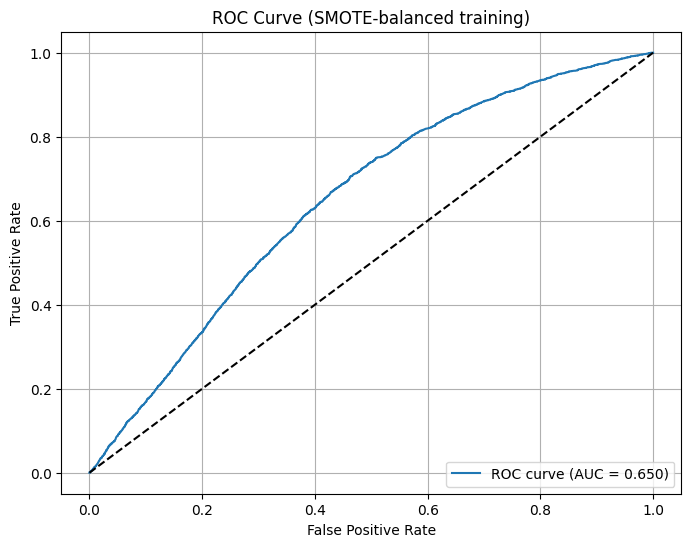

In [44]:
# Convert to PyTorch tensors using the balanced data
X_train_tensor_s = torch.tensor(X_train_balanced.to_numpy(), dtype=torch.float32)
y_train_tensor_s = torch.tensor(y_train_balanced.to_numpy(), dtype=torch.long)
X_test_tensor_s = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor_s = torch.tensor(y_test.to_numpy(), dtype=torch.long)

train_loader_s = DataLoader(TensorDataset(X_train_tensor_s, y_train_tensor_s),
                            batch_size=256, shuffle=True)

test_loader = DataLoader(TensorDataset(X_test_tensor_s, y_test_tensor_s),
                         batch_size=256)

class ModelWithDenseBlock(torch.nn.Module):
    def __init__(self, input_dim, num_trees, num_layers, depth, tree_dim,
                 choice_function, bin_function):
        super().__init__()
        self.dense_block = DenseBlock(
            input_dim=input_dim,
            layer_dim=num_trees,
            num_layers=num_layers,
            tree_dim=tree_dim,
            flatten_output=True,
            Module=ODST,
            depth=depth,
            choice_function=choice_function,
            bin_function=bin_function
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, input_dim)
            dense_output = self.dense_block(dummy_input)
            dense_output_dim = dense_output.shape[1]

        self.classifier = torch.nn.Linear(dense_output_dim, 2)

    def forward(self, x):
        x = self.dense_block(x)
        x = self.classifier(x)
        return x

# 4. Instantiate the model
entmax15 = lambda input, dim=-1: Entmax15Function.apply(input, dim)

model = ModelWithDenseBlock(
    input_dim=X_train_tensor_s.shape[1],
    num_trees=100,
    num_layers=3,
    depth=5,
    tree_dim=1,
    choice_function=entmax15,
    bin_function=sparsemax
)

# 5. Setup device and optimizer/loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

trainer = Trainer(
    model=model,
    loss_function=loss_fn,
    Optimizer=torch.optim.Adam,
    optimizer_params={'lr': 0.001},
    verbose=True
)

trainer.model.to(device)

# 6. Training loop with early stopping (same logic, just use train_loader_s)
num_epochs = 20
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader_s):  # SMOTE loader
        inputs, labels = inputs.to(device), labels.to(device)
        batch_result = trainer.train_on_batch(inputs, labels, device=device)
        total_loss += batch_result['loss'].item()

    avg_train_loss = total_loss / len(train_loader_s)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        trainer.save_checkpoint(tag='best_smote')  # give unique name
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# 7. Load best model and evaluate
trainer.load_checkpoint(tag='best_smote')  # match the save tag
model.eval()

y_pred_probs = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_pred_probs.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)
y_pred = y_pred_probs > 0.5

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

auc = roc_auc_score(y_true, y_pred_probs)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SMOTE-balanced training)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Your model was trained for up to 20 epochs, but early stopping was triggered at epoch 8 to prevent overfitting. The best validation loss was achieved at epoch 3 (Val Loss: 0.5745), and the model checkpoint from that epoch was used for evaluation. While initial training helped reduce both training and validation loss, the performance slightly plateaued after epoch 4, indicating that the model had learned the main patterns early on.

### ROC Curve Insights:
The ROC AUC is 0.650, which is above random guessing (0.5) but still far from ideal (1.0). This means the model is learning useful discriminative patterns from the data, but its ability to separate classes (especially the minority class) still has significant room for improvement. The curve rises above the diagonal, confirming the model does better than chance.

Because early stopping selected the model from epoch 3, where validation loss was lowest, you're evaluating the most generalizable version of the model — not the one that overfit to training data in later epochs.

* As a result, the model performed reasonably well, especially compared to training longer:

* Avoided overfitting, which would have hurt performance on unseen test data.

* Final AUC = 0.65 and macro average precision/recall/F1 ≈ 0.56–0.57 suggest the model captured meaningful patterns, especially with SMOTE.

* It also explains why the model showed better recall for the minority class (1) than before (35% vs 1%), which is critical in imbalanced classification.


# Summary

The implementation of a NODE-based model using DenseBlock with ODST layers allowed us to explore a hybrid deep learning approach that mimics decision tree behavior while being trainable via backpropagation. This architecture aimed to capture complex interactions in tabular data more effectively than standard deep neural networks.

The NODE-based model demonstrated moderate success in modeling structured tabular data with class imbalance. It was particularly good at quickly capturing important features and avoiding overfitting, thanks to early stopping and sparse activations. However, it also revealed the model’s sensitivity to data imbalance, showing that preprocessing techniques like SMOTE or class weighting are essential for extracting full potential from NODE in imbalanced classification tasks.

This experiment taught us that while NODE is a powerful alternative to traditional neural nets for tabular data, careful data balancing and threshold tuning are crucial for achieving strong, fair performance—especially when minority classes matter.